In [1]:
import sys
sys.path.append("/home/bl9/gempy")
import gempy as gp

%matplotlib inline
import pymc
import numpy as np
import math

from IPython.core.display import Image

from pymc.Matplot import plot
from pymc import graph

from IPython.core.pylabtools import figsize
figsize(15, 6)

import scipy.optimize as sop
import scipy.stats as stats
from scipy.signal import argrelextrema

import matplotlib.mlab as mlab
from matplotlib import pyplot as plt

import importlib

from operator import itemgetter

from mpl_toolkits.mplot3d import Axes3D

import vtk
import evtk

from scipy.interpolate import griddata

#import pydot

In [2]:
# Importing the data from csv files and setting extent and resolution
geo_data = gp.create_data([0,2000,0,2000,0,2000],[50,50,50],
                         path_f = "./input_data/Fab_ResModel_Foliations2.csv",
                         path_i = "./input_data/Fab_ResModel_Points4_small_offset.csv")
geo_data.n_faults = 1

In [3]:
#gp.get_data(geo_data)

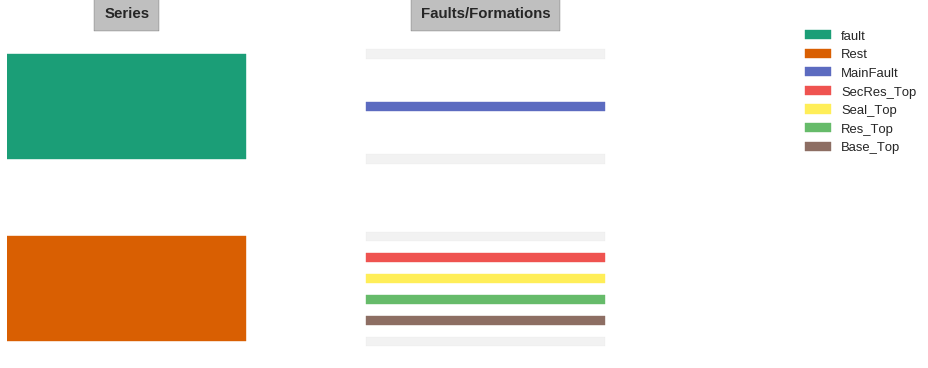

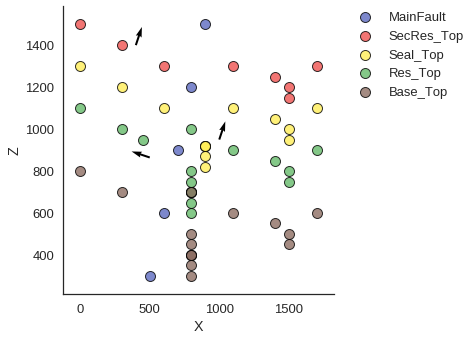

In [4]:
gp.set_series(geo_data, {"fault":'MainFault', 
                      "Rest":('Base_Top', 'Res_Top', 'Seal_Top', 'SecRes_Top')},
                       order_series = ["fault","Rest",], order_formations=['MainFault', 
                                         'SecRes_Top', 'Seal_Top', 'Res_Top','Base_Top',
                                         ])

gp.plot_data(geo_data)

In [5]:
# Creating a row label 'fault side' to distinguish between footwall (FW) and hanging wall (HW)
geo_data.interfaces['fault side'] = 'nan'
HW_border = 1300 # distance of middle of fault (border HW/FW) from footwall border of model
                # (X = 2000 - 1300 = 700)
nonfault_cond = geo_data.interfaces['formation'] != 'MainFault'
fault_cond = geo_data.interfaces['formation'] == 'MainFault'

fw_x_cond = geo_data.interfaces['X'] > (geo_data.extent[:2][1] - HW_border) # condition for F#W points

hw_x_cond = geo_data.interfaces['X'] < (geo_data.extent[:2][1] - HW_border) # condition for HW points

geo_data.interfaces.set_value(fw_x_cond,'fault side','footwall') # setting FW
geo_data.interfaces.set_value(hw_x_cond,'fault side','hanging wall') #setting HW
geo_data.interfaces.set_value(fault_cond,'fault side','nan'); # reverting fault points to 'nan'

In [6]:
# INTERPOLATION
interp_data = gp.InterpolatorData(geo_data, 
                                   u_grade = [3, 3, 3], dtype ='float64')

In [7]:
# COMPUTATION OF THE MODEL
lith_sol, fault_sol = gp.compute_model(interp_data)

Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64


/home/bl9/gempy/gempy/data_management.py:1227: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 2 but corresponding boolean dimension is 3
  n_universal_eq[u_grade == 0] = 0
/home/bl9/gempy/gempy/data_management.py:1228: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 2 but corresponding boolean dimension is 3
  n_universal_eq[u_grade == 1] = 3
/home/bl9/gempy/gempy/data_management.py:1229: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 2 but corresponding boolean dimension is 3
  n_universal_eq[u_grade == 2] = 9


In [8]:
# Arrays to hold the original compuation of the model
# These is used in case of computation failure (singular matrix) during modeling under uncertainty
lith_holder = lith_sol
fault_holder = fault_sol
interp_holder = interp_data

In [9]:
# Geo formation numbers
base_n = 0
res_n = geo_data.get_formation_number()['Base_Top']
seal_n = geo_data.get_formation_number()['Res_Top']
secres_n = geo_data.get_formation_number()['Seal_Top']
over_n = geo_data.get_formation_number()['SecRes_Top']
mainfault_n = geo_data.get_formation_number()['MainFault']

In [10]:
# CREATING SURFACES FOR LAYER INTERFACES (vertices and simplices; interfaces named as bottoms of layers)
res_surf_v, res_surf_s = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[1], potential_fault=fault_sol[1], n_formation = res_n)
seal_surf_v, seal_surf_s = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[1], potential_fault=fault_sol[1], n_formation = seal_n)
secres_surf_v, secres_surf_s = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[1], potential_fault=fault_sol[1], n_formation = secres_n)
over_surf_v, over_surf_s = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[1], potential_fault=fault_sol[1], n_formation = over_n)
#fault_surf_v, fault_surf_s = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[1], potential_fault=fault_sol[1], n_formation = mainfault_n)

In [11]:
plot_3Dpoints = False
plot_3Dsurf = False

if plot_3Dpoints:
    # 3D plot points in VTK
    gp.plot_data_3D(geo_data)
elif plot_3Dsurf:
    # 3D plot points and surfaces in VTK
    gp.plot_surfaces_3D(geo_data, [res_surf_v, seal_surf_v, secres_surf_v, over_surf_v], 
                    [res_surf_s, seal_surf_s, secres_surf_s, over_surf_s], plot_data=False
                   )

In [12]:
# DECLARING SOME MODEL VARIABLES
resolution = geo_data.resolution[1] #resolution, standard: 50
model_size = geo_data.extent[:2][1] # 'real' model extent, here: 2000 m - cubic (what if not cubic?)
scale_factor = (model_size/resolution) # scale factor used for calculating voxel volumes in [m]
                                        # here: 2000/50 = 40
rescale_f = interp_data.rescaling_factor # rescaling factor from geo_data to interp_data

#minmax_buffer = True # buffer around local min and max values [on/off] - not used atm

#SSF_c = 3

/home/bl9/gempy/gempy/visualization.py:250: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  im = plt.imshow(plot_block[_a, _b, _c].T, origin="bottom",


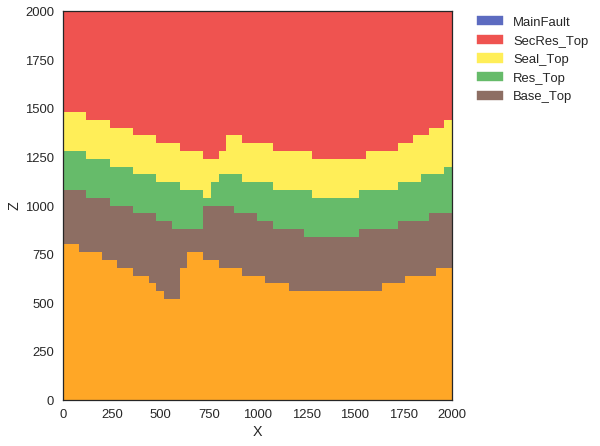

In [13]:
#%matplotlib notebook
%matplotlib inline
figsize(20,10)
gp.plot_section(geo_data, lith_sol[0], resolution/2, plot_data=0)

In [14]:
# for setting up postional conditions to determine thicknesses and the like:
fw_th_point = 900 # distance of test point for thickness from footwall border of model 
                  # (e.g.: X = 2000 - 900 = 1100)
HW_border = 1300 # distance of middle of fault (border HW/FW) from footwall border of model
                # (X = 2000 - 1300 = 700)

# SAVING ORIGINAL Z-VALUES (so they are not overwritten and can be used a base for every iteration)    
sec_res_z = interp_data.geo_data_res.interfaces[interp_data.geo_data_res.interfaces['formation'] == 'SecRes_Top']['Z']
seal_z = interp_data.geo_data_res.interfaces[interp_data.geo_data_res.interfaces['formation'] == 'Seal_Top']['Z']
res_z = interp_data.geo_data_res.interfaces[interp_data.geo_data_res.interfaces['formation'] == 'Res_Top']['Z']
base_z = interp_data.geo_data_res.interfaces[interp_data.geo_data_res.interfaces['formation'] == 'Base_Top']['Z']

# SETTING Z-UNCERTAINTIES FOR EACH LAYER TOP
unc_f = 1
std_secres_top = 40 #* unc_f
std_seal_top = 60 #* unc_f
std_res_top = 80 #* unc_f
std_base_top = 100 #* unc_f
z_unc_secres_top = pymc.Normal('z_unc_secres_top', 0, 1./np.square(std_secres_top/rescale_f))
z_unc_seal_top = pymc.Normal('z_unc_seal_top', 0/rescale_f, 1./np.square(std_seal_top/rescale_f))
z_unc_res_top = pymc.Normal('z_unc_res_top', 0, 1./np.square(std_res_top/rescale_f))
z_unc_base_top = pymc.Normal('z_unc_base_top', 0, 1./np.square(std_base_top/rescale_f))

# SETTING FAULT OFFSET UNCERTAINTY
std_offset = 150
# using SkewNormal, so that fault offset is much more like to vary to a higher offset and to stay as a normal fault
offset_unc = pymc.SkewNormal('offset_unc', -100/rescale_f, 1./np.square(std_offset/rescale_f), alpha=-2)

# GENERAL FAULT SEALING UNCERTAINTY (p = probability of success (1 = True); True = fault sealing) # NOT USED!
fault_sealing = pymc.Bernoulli('fault_sealing_unc',p=0)

In [15]:
# Boolean conditions to find data points for each formation
base_top_cond = interp_data.geo_data_res.interfaces['formation'] == 'Base_Top'
res_top_cond = interp_data.geo_data_res.interfaces['formation'] == 'Res_Top'
seal_top_cond = interp_data.geo_data_res.interfaces['formation'] == 'Seal_Top'
secres_top_cond = interp_data.geo_data_res.interfaces['formation'] == 'SecRes_Top'

# Footwall and hanging wall conditions
footwall = interp_data.geo_data_res.interfaces['fault side'] == 'footwall'
hanging_wall = interp_data.geo_data_res.interfaces['fault side'] == 'hanging wall'

# Combining hanging wall and formation conditions
HW_secres_top = np.logical_and(secres_top_cond,hanging_wall)
HW_seal_top = np.logical_and(seal_top_cond,hanging_wall)
HW_res_top = np.logical_and(res_top_cond,hanging_wall)
HW_base_top = np.logical_and(base_top_cond,hanging_wall)

In [16]:
# PYMC MODEL FUNCTIONS 

# Updating of interp_data points with new z-values resulting from z-positional uncertainty
# and including offset uncertainty:
@pymc.deterministic
def interp_unc(value=0, z_unc_secres_top = z_unc_secres_top, z_unc_seal_top=z_unc_seal_top, 
                  z_unc_res_top = z_unc_res_top, z_unc_base_top = z_unc_base_top, off_unc=offset_unc):
    #print('CHECK0:', res_z)
    new_z_secres_top = sec_res_z + z_unc_secres_top
    new_z_seal_top = seal_z + z_unc_seal_top
    new_z_res_top = res_z + z_unc_res_top
    new_z_base_top = base_z + z_unc_base_top   
    
    # for offset uncertainty: additional change on hanging wall (HW): 
    HW_new_z_secres_top = new_z_secres_top + off_unc
    HW_new_z_seal_top = new_z_seal_top + off_unc
    HW_new_z_res_top = new_z_res_top + off_unc
    HW_new_z_base_top = new_z_base_top + off_unc

    print('Z variations top to bottom:', z_unc_secres_top*rescale_f, 
          z_unc_seal_top*rescale_f, z_unc_res_top*rescale_f, z_unc_base_top*rescale_f)  
    print('Fault offset variation:', off_unc*rescale_f)
    
    # FOOTWALL UNCERTAINTY
    interp_data.geo_data_res.interfaces.set_value(secres_top_cond,'Z',new_z_secres_top)
    interp_data.geo_data_res.interfaces.set_value(seal_top_cond,'Z',new_z_seal_top)
    interp_data.geo_data_res.interfaces.set_value(res_top_cond,'Z',new_z_res_top)
    interp_data.geo_data_res.interfaces.set_value(base_top_cond,'Z',new_z_base_top)
    
    # HANGING WALL UNCERTAINTY (incl. offset)
    interp_data.geo_data_res.interfaces.set_value(HW_secres_top,'Z',HW_new_z_secres_top)
    interp_data.geo_data_res.interfaces.set_value(HW_seal_top,'Z',HW_new_z_seal_top)
    interp_data.geo_data_res.interfaces.set_value(HW_res_top,'Z',HW_new_z_res_top)
    interp_data.geo_data_res.interfaces.set_value(HW_base_top,'Z',HW_new_z_base_top)
    
    #print('CHECK3:', interp_data.geo_data_res.interfaces)    
    return interp_data

# Calculating formation thickness based on z-difference between a bottom and top point on the footwall (fw)

# This is done using interp_data, where X,Y and Z-values are rescaled according to the rescaling_factor.
# Value[1] of extent_rescaled equals the maximum extent of model (here: 2000).
# So if we want to find the rescaled chosen X-position (here: 1100), 
# we simply calculate 2000-fw_th_point(here:900) rescaled (see fw_x)
# Y_mid defines that we are looking at a central position (in y-direction) in the model.
# The difference in z between two points has to be rescaled to the original scale again.
#rescale_f = interp_data.rescaling_factor

# Reservoir thickness
@pymc.deterministic
def res_th(interp_data=interp_unc):
    fw_x = interp_data.geo_data_res.interfaces['X'] == (interp_data.geo_data_res.extent[1] - (fw_th_point/rescale_f))
    y_mid = interp_data.geo_data_res.interfaces['Y'] == (interp_data.geo_data_res.extent[3] - (1000/rescale_f))
    points_fw = interp_data.geo_data_res.interfaces[fw_x]
    points_fw = points_fw[y_mid] 
    fw_rb_z = points_fw[base_top_cond]['Z'].values*rescale_f
    fw_sb_z = points_fw[res_top_cond]['Z'].values*rescale_f
    return np.abs(fw_sb_z-fw_rb_z)

#Seal thickness
@pymc.deterministic
def seal_th(interp_data=interp_unc):
    fw_x = interp_data.geo_data_res.interfaces['X'] == (interp_data.geo_data_res.extent[1] - (fw_th_point/rescale_f))
    y_mid = interp_data.geo_data_res.interfaces['Y'] == (interp_data.geo_data_res.extent[3] - (1000/rescale_f))
    # .extent[1] = 'X'-max; .extent[3] = 'Y'-max
    points_fw = interp_data.geo_data_res.interfaces[fw_x]
    points_fw = points_fw[y_mid] 
    fw_r2b_z = points_fw[seal_top_cond]['Z'].values*rescale_f
    fw_sb_z = points_fw[res_top_cond]['Z'].values*rescale_f
    return np.abs(fw_r2b_z-fw_sb_z)

# Secondary reservoir thickness
@pymc.deterministic
def sec_res_th(interp_data=interp_unc):
    fw_x = interp_data.geo_data_res.interfaces['X'] == (interp_data.geo_data_res.extent[1] - (fw_th_point/rescale_f))
    y_mid = interp_data.geo_data_res.interfaces['Y'] == (interp_data.geo_data_res.extent[3] - (1000/rescale_f))
    points_fw = interp_data.geo_data_res.interfaces[fw_x]
    points_fw = points_fw[y_mid] 
    fw_r2b_z = points_fw[seal_top_cond]['Z'].values*rescale_f
    fw_ob_z = points_fw[secres_top_cond]['Z'].values*rescale_f
    return np.abs(fw_ob_z-fw_r2b_z)             

# Volumetric calculation 
@pymc.deterministic
def unc_model(interp_data_M=interp_unc, fault_sealing=fault_sealing, seal_th=seal_th,
                     lh=lith_holder, fh=fault_holder, idh=interp_holder, seal_n=seal_n, print_figures=False):
    try:
        lith_sol, fault_sol = gp.compute_model(interp_data_M)
        lith_block = lith_sol[0]
        fault_block = fault_sol[0]  
        seal_surf_v, seal_surf_s = gp.get_surfaces(
                                              interp_data = interp_data_M, potential_lith=lith_sol[1], 
            potential_fault=fault_sol[1], n_formation = seal_n)
        if print_figures:
            gp.plot_section(geo_data, lith_sol[0], resolution/2, plot_data =0)
            #gp.plot_section(geo_data, trap, resolution/2, plot_data =0)
        return lith_sol, fault_sol
        #return max_vol, SSF, trap_control
        
    except np.linalg.linalg.LinAlgError as err:
        # In case of LinAlgError, use original model
        print('LinAlgError occurred!')
        lith_sol = lh
        fault_sol = fh
        lith_block = lith_sol[0]
        fault_block = fault_sol[0] 
        seal_surf_v, seal_surf_s = gp.get_surfaces(
                                              interp_data = interp_data_M, potential_lith=lith_sol[1], 
            potential_fault=fault_sol[1], n_formation = seal_n)
        return lith_sol, fault_sol
        #return max_vol, SSF, trap_control
    
    ### RETURN INDICES:
    ### 0 = lith_sol
    ### 1 = fault_sol
    ### 2 = max_vol (maximum trap volume)
    ### 3 = trap (block)
    ### 4 = SSF (Shale Smear Factor)
    ### 5 = trap_control (controling mechanism for max trap volume)

Z variations top to bottom: 53.9505850222 -96.2407376389 94.9388191287 31.6815944599
Fault offset variation: -165.187033023


/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:55: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:56: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:57: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:67: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:68: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Serie

In [17]:
iterations = 100

In [18]:
model = pymc.Model([interp_unc, z_unc_res_top, z_unc_base_top, z_unc_seal_top, z_unc_secres_top, offset_unc, fault_sealing, unc_model, res_th, seal_th, sec_res_th])
#model = pymc.Model([interp_unc, z_unc_res_top, z_unc_base_top, z_unc_seal_top, z_unc_secres_top, offset_unc, fault_sealing, structural_model, res_th, seal_th, sec_res_th, over_jux_area])

In [19]:
M = pymc.MCMC(model)
#M = pymc.MCMC(model,db= "hdf5" , dbname= "D:/PyMC_DataBase/prior_model_noBlocks_SSFc_3_1000iter_2017_11_12")
M.sample(iter=iterations)

Z variations top to bottom: 12.639907465 -13.3403150678 -81.0892912193 -74.7361033469
Fault offset variation: -299.086774556


/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:55: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:56: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:57: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:80: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:67: UserWarning: Boolean Serie

 [                  2%                  ] 2 of 100 complete in 7.1 secZ variations top to bottom: 29.5585757679 -34.7879984389 -108.958608038 -8.44069671277
Fault offset variation: -160.020739616
 [-                 3%                  ] 3 of 100 complete in 14.2 secZ variations top to bottom: -21.3187665696 -53.2632735375 -9.91819961122 24.2190248961
Fault offset variation: -54.5335121906
 [-                 4%                  ] 4 of 100 complete in 21.2 secZ variations top to bottom: -6.96381842464 -161.395829354 -35.743645969 29.0369222537
Fault offset variation: -98.256690935
 [-                 5%                  ] 5 of 100 complete in 28.2 secZ variations top to bottom: -80.763122536 57.3076020367 52.3486441058 112.201466259
Fault offset variation: -320.141024156
 [--                6%                  ] 6 of 100 complete in 35.1 secZ variations top to bottom: 6.37481673189 -7.78866636561 67.3245154357 -161.587176233
Fault offset variation: -166.807556919
 [--                7%

 [---------------- 44%                  ] 44 of 100 complete in 323.5 secZ variations top to bottom: -3.61379523216 -12.7356946912 -6.02093013357 36.3843115088
Fault offset variation: -294.076780409
 [-----------------45%                  ] 45 of 100 complete in 331.4 secZ variations top to bottom: -65.1232820166 -62.3652501179 3.49776824115 19.3575057926
Fault offset variation: -41.5774744944
 [-----------------46%                  ] 46 of 100 complete in 339.4 secZ variations top to bottom: 23.2242660469 20.6810871679 -63.1652704249 -100.840768292
Fault offset variation: -150.400668356
 [-----------------47%                  ] 47 of 100 complete in 347.3 secZ variations top to bottom: -39.9040954398 -83.4943433691 -46.9641978426 -166.431023687
Fault offset variation: -236.228392169
 [-----------------48%                  ] 48 of 100 complete in 355.2 secZ variations top to bottom: 1.39428442283 14.783839702 -71.8809725469 208.180411973
Fault offset variation: -169.160094115
 [-------

 [-----------------86%------------      ] 86 of 100 complete in 660.0 secZ variations top to bottom: -32.1804127514 -163.207338675 15.8491626981 -125.473040197
Fault offset variation: -315.884769828
 [-----------------87%-------------     ] 87 of 100 complete in 668.2 secZ variations top to bottom: -16.0935359479 38.8404536957 -91.1512869613 3.16081214979
Fault offset variation: -335.290529306
 [-----------------88%-------------     ] 88 of 100 complete in 676.2 secZ variations top to bottom: 60.9970319644 -57.8650968042 -51.4317061244 -165.145615302
Fault offset variation: -194.580967779
 [-----------------89%-------------     ] 89 of 100 complete in 684.1 secZ variations top to bottom: 75.2570369328 -28.444551755 29.1228335718 143.836510547
Fault offset variation: -331.353249696
 [-----------------90%--------------    ] 90 of 100 complete in 692.0 secZ variations top to bottom: -60.3926904094 43.8533913171 96.9458038666 111.918640746
Fault offset variation: -332.973686914
 [---------

In [20]:
res_top_unc_trace = M.trace('z_unc_res_top')[:]
offset_unc_trace = M.trace('offset_unc')[:]
fault_sealing_trace = M.trace('fault_sealing_unc')[:]
interp_trace = M.trace('interp_unc')[:]
#over_jux_area_trace = M.trace('over_jux_area')[:] 

fw_res_th_trace = M.trace('res_th')[:]
fw_seal_th_trace = M.trace('seal_th')[:]
fw_sec_res_th_trace = M.trace('sec_res_th')[:]

unc_model_trace = M.trace('unc_model')[:]

/home/bl9/gempy/gempy/visualization.py:250: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  im = plt.imshow(plot_block[_a, _b, _c].T, origin="bottom",


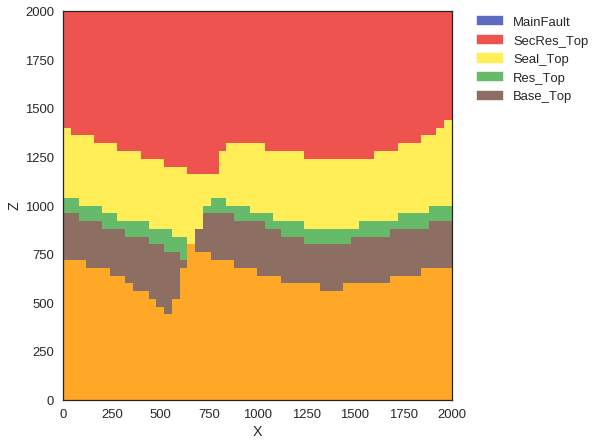

In [21]:
# Use first index position of unc_model_trace to look at solutions from different iterations
gp.plot_section(geo_data, unc_model_trace[3][0][0], resolution/2, plot_data =0)

In [22]:
# INFORMATION ENTROPY FUNCTIONS
def compute_prob_lith(lith_blocks):
    """Blocks must be just the lith blocks!"""
    lith_id = np.unique(lith_blocks)
    lith_count = np.zeros_like(lith_blocks[0:len(lith_id)])
    for i, l_id in enumerate(lith_id):
        lith_count[i] = np.sum(lith_blocks == l_id, axis=0)
    lith_prob = lith_count / len(lith_blocks)
    return lith_prob


def calculate_ie_masked(lith_prob):
    ie = np.zeros_like(lith_prob[0])
    for l in lith_prob:
        pm = np.ma.masked_equal(l, 0)  # mask where layer prob is 0
        ie -= (pm * np.ma.log2(pm)).filled(0)
    return ie


def calculate_ie_total(ie, absolute=False):
    if absolute:
        return np.sum(ie)
    else:
        return np.sum(ie) / np.size(ie)

In [23]:
lith_blocks = []
for i in unc_model_trace[:]:
    #print(i[0][0])
    lith_blocks.append(i[0][0])

lith_prob = compute_prob_lith(lith_blocks)
i_entropy = calculate_ie_masked(lith_prob)

/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  """


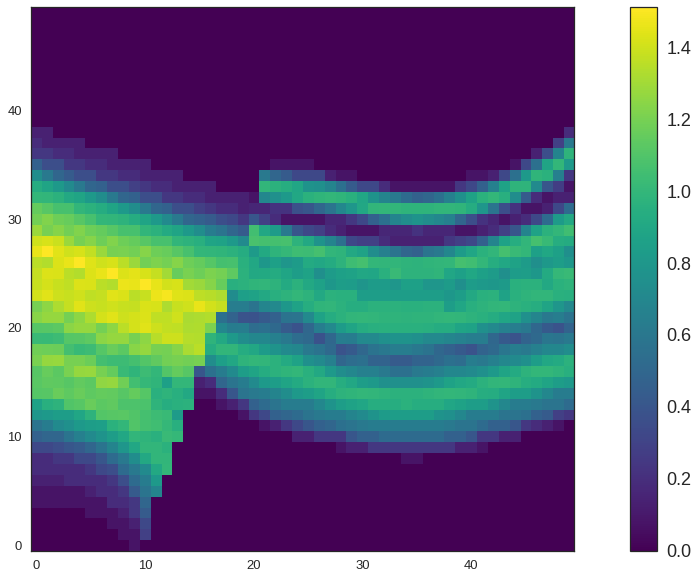

In [24]:
figsize(20,10)
fig, ax = plt.subplots(1)
plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18) 
plt.imshow(i_entropy.reshape(resolution,resolution,resolution)[:,resolution/2,:].T, origin="lower", cmap="viridis")
plt.colorbar()

In [25]:
### LIKELIHOOD FUNCTIONS

# THICKNESS LIKELIHOODS
#Additional information, updating with likelihoods
std1 = 30
std2 = 30
std3 = 30

@pymc.stochastic
def sec_res_th_likelihood(value = 0, sec_res_th=sec_res_th):
    return pymc.normal_like(sec_res_th, 150., 1./np.square(std1))

@pymc.stochastic
def seal_th_likelihood(value = 0, seal_th=seal_th):
    return pymc.normal_like(seal_th, 350., 1./np.square(std2))

@pymc.stochastic
def res_th_likelihood(value = 0, res_th=res_th):
    return pymc.normal_like(res_th, 250., 1./np.square(std3))

In [26]:
# Model inclucing only thickness likelihoods
model_L = pymc.Model([interp_unc, z_unc_res_top, z_unc_base_top, z_unc_seal_top, z_unc_secres_top, offset_unc,
                        fault_sealing, unc_model, 
                        res_th, seal_th, sec_res_th, res_th_likelihood, seal_th_likelihood, sec_res_th_likelihood])

In [27]:
iterations= 110

In [28]:
M_L = pymc.MCMC(model_L)
#M_L = pymc.MCMC(model_L,db= "hdf5" , dbname= "D:/PyMC_DataBase/post_model_300_30-050_10-400_40_1000iter50burn.hdf5")
M_L.sample(iter=iterations, burn=10)

Z variations top to bottom: -1.17010110544 42.7814708324 -4.1102782859 116.37553135
Fault offset variation: -264.914562043
Z variations top to bottom: -1.17010110544 42.7814708324 -4.1102782859 129.595924614
Fault offset variation: -264.914562043
Z variations top to bottom: -1.17010110544 42.7814708324 -7.03949725325 116.37553135
Fault offset variation: -264.914562043


/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:55: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:56: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:57: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:80: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:67: UserWarning: Boolean Serie

Z variations top to bottom: -1.17010110544 42.7814708324 -7.03949725325 116.37553135
Fault offset variation: 68.1844288307
Z variations top to bottom: -1.17010110544 26.1074989813 -7.03949725325 116.37553135
Fault offset variation: -264.914562043
Z variations top to bottom: -1.17010110544 42.7814708324 -7.03949725325 116.37553135
Fault offset variation: -264.914562043
Z variations top to bottom: 0.905022935371 42.7814708324 -7.03949725325 116.37553135
Fault offset variation: -264.914562043
Z variations top to bottom: 0.905022935371 42.7814708324 -7.03949725325 142.632208852
Fault offset variation: -264.914562043
Z variations top to bottom: 0.905022935371 42.7814708324 -4.83985308836 116.37553135
Fault offset variation: -264.914562043
Z variations top to bottom: 0.905022935371 42.7814708324 -4.83985308836 116.37553135
Fault offset variation: 50.6722305625
Z variations top to bottom: 0.905022935371 167.111751484 -4.83985308836 116.37553135
Fault offset variation: -264.914562043
Z variati

/home/bl9/gempy/gempy/data_management.py:1227: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 2 but corresponding boolean dimension is 3
  n_universal_eq[u_grade == 0] = 0
/home/bl9/gempy/gempy/data_management.py:1228: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 2 but corresponding boolean dimension is 3
  n_universal_eq[u_grade == 1] = 3
/home/bl9/gempy/gempy/data_management.py:1229: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 2 but corresponding boolean dimension is 3
  n_universal_eq[u_grade == 2] = 9


 [----             10%                  ] 12 of 110 complete in 12.5 secZ variations top to bottom: -3.11110106552 86.1305632778 -10.9352787097 67.9461484577
Fault offset variation: -155.664214645
Z variations top to bottom: -3.11110106552 86.1305632778 -10.9352787097 169.844395061
Fault offset variation: -155.664214645
Z variations top to bottom: -3.11110106552 86.1305632778 -16.0172943593 67.9461484577
Fault offset variation: -155.664214645
Z variations top to bottom: -3.11110106552 86.1305632778 -16.0172943593 67.9461484577
Fault offset variation: -128.304066868
Z variations top to bottom: -3.11110106552 47.6314329717 -16.0172943593 67.9461484577
Fault offset variation: -128.304066868
 [----             11%                  ] 13 of 110 complete in 20.8 secZ variations top to bottom: -2.43692224432 86.1305632778 -16.0172943593 67.9461484577
Fault offset variation: -128.304066868
Z variations top to bottom: -2.43692224432 86.1305632778 -16.0172943593 -264.54385484
Fault offset variati

Z variations top to bottom: -0.450030921468 81.0474184963 -17.0414784908 69.3524735159
Fault offset variation: -107.559097611
Z variations top to bottom: -0.450030921468 81.0474184963 -17.0414784908 69.3524735159
Fault offset variation: 33.3010162426
Z variations top to bottom: -0.450030921468 59.3144805942 -17.0414784908 69.3524735159
Fault offset variation: -107.559097611
 [--------         21%                  ] 24 of 110 complete in 112.0 secZ variations top to bottom: 0.443504490387 59.3144805942 -17.0414784908 69.3524735159
Fault offset variation: -107.559097611
Z variations top to bottom: 0.443504490387 59.3144805942 -17.0414784908 274.119586845
Fault offset variation: -107.559097611
Z variations top to bottom: 0.443504490387 59.3144805942 -10.1435146457 69.3524735159
Fault offset variation: -107.559097611
Z variations top to bottom: 0.443504490387 59.3144805942 -10.1435146457 69.3524735159
Fault offset variation: -139.122300654
Z variations top to bottom: 0.443504490387 67.0032

 [------------     31%                  ] 35 of 110 complete in 202.6 secZ variations top to bottom: -3.23996306142 95.4612612632 -17.9298946081 72.664993596
Fault offset variation: -211.476915701
Z variations top to bottom: -3.23996306142 95.4612612632 -17.9298946081 113.700630318
Fault offset variation: -211.476915701
Z variations top to bottom: -3.23996306142 95.4612612632 -22.4818704618 72.664993596
Fault offset variation: -211.476915701
Z variations top to bottom: -3.23996306142 95.4612612632 -17.9298946081 72.664993596
Fault offset variation: -211.476915701
Z variations top to bottom: -3.23996306142 95.4612612632 -17.9298946081 72.664993596
Fault offset variation: -243.663510103
Z variations top to bottom: -3.23996306142 119.653478156 -17.9298946081 72.664993596
Fault offset variation: -243.663510103
 [------------     32%                  ] 36 of 110 complete in 210.4 secZ variations top to bottom: -3.3723564748 119.653478156 -17.9298946081 72.664993596
Fault offset variation: -

Z variations top to bottom: 1.52462289765 75.3517890851 -27.7009091334 -7.55484205535
Fault offset variation: -177.265617371
Z variations top to bottom: 1.52462289765 75.3517890851 -27.7009091334 -7.55484205535
Fault offset variation: -165.010998162
Z variations top to bottom: 1.52462289765 92.6639818751 -27.7009091334 -7.55484205535
Fault offset variation: -165.010998162
 [---------------- 42%                  ] 47 of 110 complete in 299.5 secZ variations top to bottom: 1.99136399132 92.6639818751 -27.7009091334 -7.55484205535
Fault offset variation: -165.010998162
Z variations top to bottom: 1.99136399132 92.6639818751 -27.7009091334 -38.2089422585
Fault offset variation: -165.010998162
Z variations top to bottom: 1.99136399132 92.6639818751 -22.7579226565 -7.55484205535
Fault offset variation: -165.010998162
Z variations top to bottom: 1.99136399132 92.6639818751 -27.7009091334 -7.55484205535
Fault offset variation: -165.010998162
Z variations top to bottom: 1.99136399132 92.6639818

 [-----------------51%                  ] 57 of 110 complete in 374.5 secZ variations top to bottom: 6.59273700674 42.0691905188 -36.343368352 -21.3402740652
Fault offset variation: -465.297074379
Z variations top to bottom: 6.59273700674 42.0691905188 -36.343368352 -244.411648457
Fault offset variation: -465.297074379
Z variations top to bottom: 6.59273700674 42.0691905188 -31.7198992436 -21.3402740652
Fault offset variation: -465.297074379
Z variations top to bottom: 6.59273700674 42.0691905188 -31.7198992436 -21.3402740652
Fault offset variation: -318.979671271
Z variations top to bottom: 6.59273700674 51.9802501933 -31.7198992436 -21.3402740652
Fault offset variation: -318.979671271
 [-----------------52%                  ] 58 of 110 complete in 381.8 secZ variations top to bottom: 7.55596274751 51.9802501933 -31.7198992436 -21.3402740652
Fault offset variation: -318.979671271
Z variations top to bottom: 7.55596274751 51.9802501933 -31.7198992436 -126.924487244
Fault offset variati

 [-----------------61%---               ] 68 of 110 complete in 455.9 secZ variations top to bottom: 10.9863342274 93.2711907332 -27.8890489319 -0.300829284901
Fault offset variation: -245.113373667
Z variations top to bottom: 10.9863342274 93.2711907332 -27.8890489319 127.711511153
Fault offset variation: -245.113373667
Z variations top to bottom: 10.9863342274 93.2711907332 -26.0415245011 -0.300829284901
Fault offset variation: -245.113373667
Z variations top to bottom: 10.9863342274 93.2711907332 -26.0415245011 -0.300829284901
Fault offset variation: -444.520312787
Z variations top to bottom: 10.9863342274 67.1093598277 -26.0415245011 -0.300829284901
Fault offset variation: -444.520312787
 [-----------------62%---               ] 69 of 110 complete in 463.2 secZ variations top to bottom: 12.0744940572 93.2711907332 -26.0415245011 -0.300829284901
Fault offset variation: -444.520312787
Z variations top to bottom: 12.0744940572 93.2711907332 -26.0415245011 -8.3249100575
Fault offset va

 [-----------------71%-------           ] 79 of 110 complete in 538.6 secZ variations top to bottom: 13.5070525995 103.664029553 -32.5610531976 67.7742514026
Fault offset variation: -144.195233093
Z variations top to bottom: 13.5070525995 103.664029553 -32.5610531976 172.188978159
Fault offset variation: -144.195233093
Z variations top to bottom: 13.5070525995 103.664029553 -34.9766568289 67.7742514026
Fault offset variation: -144.195233093
Z variations top to bottom: 13.5070525995 103.664029553 -34.9766568289 67.7742514026
Fault offset variation: -222.284503642
Z variations top to bottom: 13.5070525995 27.4752172228 -34.9766568289 67.7742514026
Fault offset variation: -222.284503642
 [-----------------72%-------           ] 80 of 110 complete in 545.9 secZ variations top to bottom: 13.1265067697 103.664029553 -34.9766568289 67.7742514026
Fault offset variation: -222.284503642
Z variations top to bottom: 13.1265067697 103.664029553 -34.9766568289 -121.596910001
Fault offset variation: 

 [-----------------81%-----------       ] 90 of 110 complete in 622.3 secZ variations top to bottom: 9.29801550295 54.5883369825 -49.9025730851 -2.81726010052
Fault offset variation: -131.64648194
Z variations top to bottom: 9.29801550295 54.5883369825 -49.9025730851 16.8425973635
Fault offset variation: -131.64648194
Z variations top to bottom: 9.29801550295 54.5883369825 -50.1798218988 16.8425973635
Fault offset variation: -131.64648194
Z variations top to bottom: 9.29801550295 54.5883369825 -50.1798218988 16.8425973635
Fault offset variation: -164.654997248
Z variations top to bottom: 9.29801550295 22.2371786289 -50.1798218988 16.8425973635
Fault offset variation: -164.654997248
 [-----------------82%-----------       ] 91 of 110 complete in 629.7 secZ variations top to bottom: 8.78690053413 54.5883369825 -50.1798218988 16.8425973635
Fault offset variation: -164.654997248
Z variations top to bottom: 8.78690053413 54.5883369825 -50.1798218988 -57.0168319454
Fault offset variation: -1

Fault offset variation: 184.451829789
Z variations top to bottom: 7.38104105443 7.57270120826 -48.513460546 29.5086735204
Fault offset variation: -114.81361612
Z variations top to bottom: 7.38104105443 67.0891243937 -48.513460546 29.5086735204
Fault offset variation: -114.81361612
 [-----------------92%---------------   ] 102 of 110 complete in 711.5 secZ variations top to bottom: 7.93224419321 67.0891243937 -48.513460546 29.5086735204
Fault offset variation: -114.81361612
Z variations top to bottom: 7.93224419321 67.0891243937 -48.513460546 107.563728954
Fault offset variation: -114.81361612
Z variations top to bottom: 7.93224419321 67.0891243937 -39.6240900458 29.5086735204
Fault offset variation: -114.81361612
Z variations top to bottom: 7.93224419321 67.0891243937 -39.6240900458 29.5086735204
Fault offset variation: -559.130416802
Z variations top to bottom: 7.93224419321 73.5168009261 -39.6240900458 29.5086735204
Fault offset variation: -114.81361612
 [-----------------93%--------

In [29]:
res_top_unc_trace_L = M_L.trace('z_unc_res_top')[:]
offset_unc_trace_L = M_L.trace('offset_unc')[:]
fault_sealing_trace_L = M_L.trace('fault_sealing_unc')[:]
interp_trace_L = M_L.trace('interp_unc')[:]
#over_jux_area_trace_L = M_L.trace('over_jux_area')[:] 

fw_res_th_trace_L = M_L.trace('res_th')[:]
fw_seal_th_trace_L = M_L.trace('seal_th')[:]
fw_sec_res_th_trace_L = M_L.trace('sec_res_th')[:]

unc_model_trace_L = M_L.trace('unc_model')[:]


In [30]:
lith_blocks = []
for i in unc_model_trace_L[:]:
    #print(i[0][0])
    lith_blocks.append(i[0][0])

lith_prob = compute_prob_lith(lith_blocks)
i_entropy = calculate_ie_masked(lith_prob)

/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  """


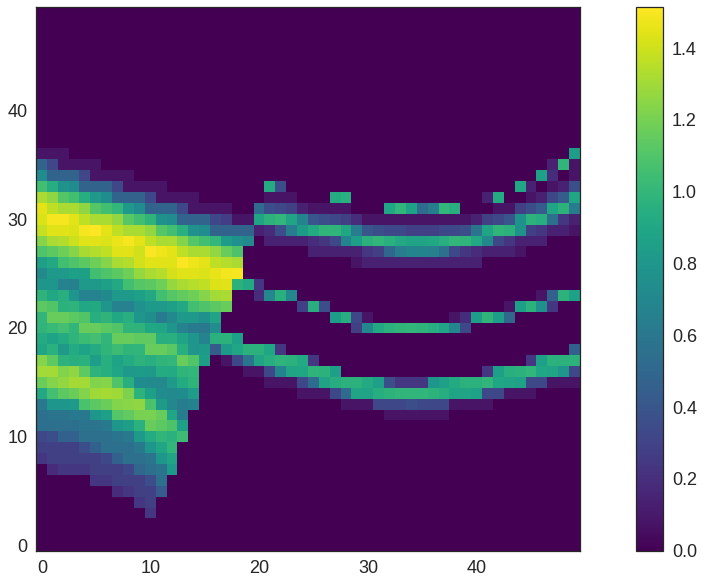

In [31]:
figsize(20,10)
fig, ax = plt.subplots(1)
plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18) 
plt.imshow(i_entropy.reshape(resolution,resolution,resolution)[:,resolution/2,:].T, origin="lower", cmap="viridis")
plt.colorbar()

In [32]:
# FOR EXPORTING TO USE IN PARAVIEW:
export = False

if export:
    counter = 0
    for i in unc_model_trace[:]:
        counter+=1
        #print(np.ascontiguousarray(i[3]))
        gp.export_vtk_rectilinear(geo_data, np.ascontiguousarray(i[0][0]), path="./output_data/lith_blocks/model_name_lith_%s" % (counter))